In [1]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
# %load_ext autoreload
# %autoreload 2
# %pdb
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np
import pickle

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib import cm
# mpl.rc('image', cmap='gray')

# import gpumap
# import umap, shap
# import umap.plot
from adjustText import adjust_text

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap

%matplotlib notebook

import visualizations as viz_util
import project as proj
# import pointnets as ptn

np.set_printoptions(linewidth=120)

In [2]:
%matplotlib notebook

In [ ]:
# dataset = trn.get_dataset('mpi3d', category='toy', train=True, labeled=True)
# dataset = trn.get_dataset('3dshapes', train=None, labeled=True)
# len(dataset)

In [3]:
def save_fig(name):
    plt.savefig(f'figures/{name}.png')
    plt.savefig(f'figures/{name}.pdf')
    print(name, 'saved')

In [23]:
shapes3d = '''
t3ds-shapes-ae-12b1-conv_0008-6337836-10_200509-130720
t3ds-shapes-vae-b1-conv_0008-6337836-04_200509-130733
t3ds-shapes-vae-b16-conv_0008-6337836-05_200509-130729
t3ds-shapes-vae-b1-dislib_0008-6337836-01_200509-130731
t3ds-shapes-vae-b16-dislib_0008-6337836-02_200509-130744
t3ds-shapes-ae-conv_0008-6337836-03_200509-130726


t3ds-shapes-ae-12b1-conv_0010-6339705-00_200509-233443
t3ds-shapes-vae-b1-conv_0010-6339705-06_200509-233330
t3ds-shapes-vae-b16-conv_0010-6339705-04_200509-233331
t3ds-shapes-vae-b1-dislib_0010-6339705-05_200509-233352
t3ds-shapes-vae-b16-dislib_0010-6339705-08_200509-233335
t3ds-shapes-ae-conv_0010-6339705-03_200509-233342
'''
shapes3d = [
    't3ds-shapes-ae-12b1-conv_0008-6337836-10_200509-130720', 
    't3ds-shapes-vae-b1-conv_0008-6337836-04_200509-130733', 
    't3ds-shapes-vae-b16-conv_0008-6337836-05_200509-130729', 
#             't3ds-shapes-vae-b1-dislib_0008-6337836-01_200509-130731', 
#             't3ds-shapes-vae-b16-dislib_0008-6337836-02_200509-130744', 
    't3ds-shapes-ae-conv_0008-6337836-03_200509-130726', 
]
shapes2 = [
    't3ds-shapes-ae-12b1-conv_0010-6339705-00_200509-233443', 
    't3ds-shapes-vae-b1-conv_0010-6339705-06_200509-233330', 
    't3ds-shapes-vae-b16-conv_0010-6339705-04_200509-233331', 
#             't3ds-shapes-vae-b1-dislib_0010-6339705-05_200509-233352', 
#             't3ds-shapes-vae-b16-dislib_0010-6339705-08_200509-233335', 
    't3ds-shapes-ae-conv_0010-6339705-03_200509-233342'
]
shapes3d_names = ['12Br', 'VAE', r'$\beta$VAE', 'AE']
shapes3d = (shapes3d_names, shapes3d, shapes2)


toy_sizes = ['tmpi-sizes-ae-toy-12b1-conv_0019-6352187-00_200516-020124',
# 'tmpi-sizes-ae-toy-12b1-conv-s2_0019-6352187-07_200516-021651',
'tmpi-sizes-vae-toy-b1-conv_0019-6352187-06_200516-021559',
'tmpi-sizes-vae-toy-b2-conv_0019-6352187-01_200516-020229',
# 'tmpi-sizes-vae-toy-b1-dislib_0019-6352187-04_200516-020653',
# 'tmpi-sizes-vae-toy-b2-dislib_0019-6352187-02_200516-020402',
'tmpi-sizes-ae-toy-conv_0019-6352187-05_200516-020656',
            ]  
toy_sizes2=[
'tmpi-sizes-ae-toy-12b1-conv_0026-6357649-00_200517-002046',
# 'tmpi-sizes-ae-toy-12b1-conv-s2_0026-6357649-07_200517-003324',
'tmpi-sizes-vae-toy-b1-conv_0026-6357649-06_200517-002521',
'tmpi-sizes-vae-toy-b2-conv_0026-6357649-01_200517-002042',
# 'tmpi-sizes-vae-toy-b1-dislib_0026-6357649-04_200517-002319',
# 'tmpi-sizes-vae-toy-b2-dislib_0026-6357649-02_200517-002044',
# 'tmpi-sizes-ae-toy-dislib_0026-6357649-03_200517-002319',
'tmpi-sizes-ae-toy-conv_0026-6357649-05_200517-002520'
]
toy_sizes_names = ['12Br', 'VAE', '$\\beta$VAE', 'AE']
toy_sizes = (toy_sizes_names, toy_sizes, toy_sizes2)

real_size = [
    'tmpi-sizes-ae-real-12b1-conv_0023-6352332-00_200516-042131',
# 'tmpi-sizes-ae-real-12b1-conv-s2_0023-6352332-07_200516-044716',
'tmpi-sizes-vae-real-b1-conv_0023-6352332-06_200516-044716',
'tmpi-sizes-vae-real-b2-conv_0023-6352332-01_200516-042315',
# 'tmpi-sizes-vae-real-b1-dislib_0023-6352332-04_200516-042840',
# 'tmpi-sizes-vae-real-b2-dislib_0023-6352332-02_200516-042814',
'tmpi-sizes-ae-real-conv_0023-6352332-05_200516-042840',
# 'tmpi-sizes-ae-real-dislib_0023-6352332-03_200516-042813',
            ]
real_size2 = [
'tmpi-sizes-ae-real-12b1-conv_0027-6357650-00_200517-004052',
# 'tmpi-sizes-ae-real-12b1-conv-s2_0027-6357650-07_200517-013343',
'tmpi-sizes-vae-real-b1-conv_0027-6357650-06_200517-013340',
'tmpi-sizes-vae-real-b2-conv_0027-6357650-01_200517-004509',
# 'tmpi-sizes-vae-real-b2-dislib_0027-6357650-03_200517-013247',
# 'tmpi-sizes-vae-real-b1-dislib_0027-6357650-05_200517-013336',
# 'tmpi-sizes-ae-real-dislib_0027-6357650-02_200517-013247',
'tmpi-sizes-ae-real-conv_0027-6357650-04_200517-013345'
]
real_sizes = (toy_sizes_names, real_size, real_size2)


toy_shapes = [
    'tmpi-shapes-ae-toy-12b1-conv_0025-6352334-00_200516-065917',
# 'tmpi-shapes-ae-toy-12b1-conv-s2_0025-6352334-07_200516-081525',
'tmpi-shapes-vae-toy-b1-conv_0025-6352334-06_200516-080145',
'tmpi-shapes-vae-toy-b2-conv_0025-6352334-01_200516-070414',
# 'tmpi-shapes-vae-toy-b1-dislib_0025-6352334-04_200516-073618',
# 'tmpi-shapes-vae-toy-b2-dislib_0025-6352334-02_200516-071120',
# 'tmpi-shapes-ae-toy-dislib_0025-6352334-03_200516-073329',
'tmpi-shapes-ae-toy-conv_0025-6352334-05_200516-080143',
             ]
toy_shapes2 = [
'tmpi-shapes-ae-toy-12b1-conv_0029-6357652-00_200517-021120',
# 'tmpi-shapes-ae-toy-12b1-conv-s2_0029-6357652-07_200517-021252',
'tmpi-shapes-vae-toy-b1-conv_0029-6357652-06_200517-021252',
'tmpi-shapes-vae-toy-b2-conv_0029-6357652-01_200517-015851',
# 'tmpi-shapes-vae-toy-b1-dislib_0029-6357652-04_200517-020750',
# 'tmpi-shapes-vae-toy-b2-dislib_0029-6357652-02_200517-020148',
# 'tmpi-shapes-ae-toy-dislib_0029-6357652-03_200517-020655',
'tmpi-shapes-ae-toy-conv_0029-6357652-05_200517-020945'
]
toy_shapes = (toy_sizes_names, toy_shapes, toy_shapes2)


real_shapes = [
    'tmpi-shapes-ae-real-12b1-conv_0024-6352333-00_200516-045012',
# 'tmpi-shapes-ae-real-12b1-conv-s2_0024-6352333-07_200516-052916',
'tmpi-shapes-vae-real-b1-conv_0024-6352333-06_200516-052106',
'tmpi-shapes-vae-real-b2-conv_0024-6352333-01_200516-045110',
# 'tmpi-shapes-vae-real-b1-dislib_0024-6352333-04_200516-045409',
# 'tmpi-shapes-vae-real-b2-dislib_0024-6352333-02_200516-045414',
'tmpi-shapes-ae-real-conv_0024-6352333-05_200516-045535',
# 'tmpi-shapes-ae-real-dislib_0024-6352333-03_200516-045408',
]
real_shapes2 = [
'tmpi-shapes-ae-real-12b1-conv_0028-6357651-00_200517-013342',
# 'tmpi-shapes-ae-real-12b1-conv-s2_0028-6357651-07_200517-014205',
'tmpi-shapes-vae-real-b1-conv_0028-6357651-06_200517-014147',
'tmpi-shapes-vae-real-b2-conv_0028-6357651-01_200517-013344',
# 'tmpi-shapes-vae-real-b1-dislib_0028-6357651-03_200517-013344',
# 'tmpi-shapes-vae-real-b2-dislib_0028-6357651-04_200517-013349',
# 'tmpi-shapes-ae-real-dislib_0028-6357651-02_200517-013348',
'tmpi-shapes-ae-real-conv_0028-6357651-05_200517-013845'
]
real_shapes = (toy_sizes_names, real_shapes, real_shapes2)

In [24]:
# print(repr([l for l in real_shapes.split('\n') if len(l) > 1]).replace(', ', ',\n'))

In [61]:
objs = [shapes3d, toy_sizes, real_sizes, toy_shapes, real_shapes]
ds_names = ['3D-Shapes', 'MPI3D Toy Sizes', 'MPI3D Real Sizes', 'MPI3D Toy Shapes', 'MPI3D Real Shapes']
idx = 4
ds = ds_names[idx]
runs = util.Table()
for n,r1,r2 in zip(*objs[idx]):
    runs.new(name=n, rname1=r1, rname2=r2)
len(runs)

4

In [62]:
runs

t[t{'name':'12Br', 'rname1':'tmpi-shapes-ae-toy-12b1-conv_0025-6352334-00_200516-065917', 'rname2':'tmpi-shapes-ae-toy-12b1-conv_0029-6357652-00_200517-021120'}, t{'name':'VAE', 'rname1':'tmpi-shapes-vae-toy-b1-conv_0025-6352334-06_200516-080145', 'rname2':'tmpi-shapes-vae-toy-b1-conv_0029-6357652-06_200517-021252'}, t{'name':'$\\beta$VAE', 'rname1':'tmpi-shapes-vae-toy-b2-conv_0025-6352334-01_200516-070414', 'rname2':'tmpi-shapes-vae-toy-b2-conv_0029-6357652-01_200517-015851'}, t{'name':'AE', 'rname1':'tmpi-shapes-ae-toy-conv_0025-6352334-05_200516-080143', 'rname2':'tmpi-shapes-ae-toy-conv_0029-6357652-05_200517-020945'}]

In [63]:
for run in tqdm(runs):
    run.results1 = torch.load(os.path.join(os.environ['FOUNDATION_SAVE_DIR'], run.rname1, 'results.pth.tar'))
    run.train1 = run.results1['train']
    run.upd1 = run.results1['upd']
    
    run.results2 = torch.load(os.path.join(os.environ['FOUNDATION_SAVE_DIR'], run.rname2, 'results.pth.tar'))
    run.train2 = run.results2['train']
    run.upd2 = run.results2['upd']
    

In [64]:
print(run.upd2.keys())
print(run.upd2['out'].keys())

dict_keys(['out', 'stats', 'stats_num', 'gt_fid_stats', 'rec_fid_stats', 'rec_fid', 'hyb_fid_stats', 'hyb_fid'])
odict_keys(['original', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs'])


In [65]:
# run.upd2['out']['reconstruction']

In [66]:
list(runs.select('name'))

['12Br', 'VAE', '$\\beta$VAE', 'AE']

<IPython.core.display.Javascript object>


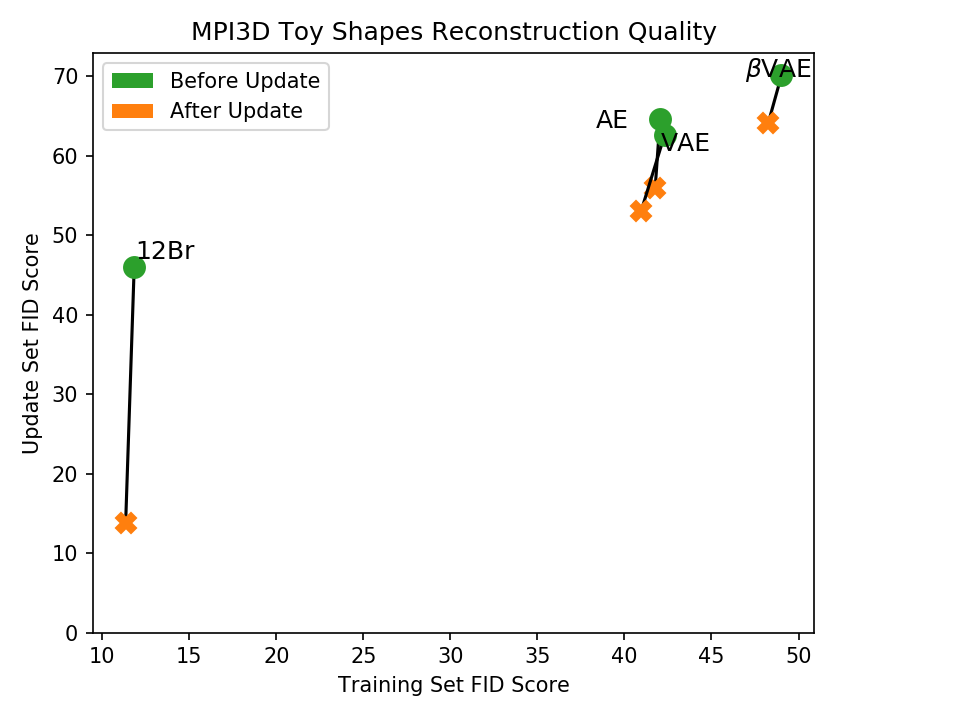

In [67]:
fig, ax = plt.subplots()#figsize=fsize)
texts = []
tps = set()
ms = 10
df = [(0,0),(0,-5),(5,0),(-4,0)]
for r,(dx,dy) in zip(runs,df):
    plt.plot([r.train1['rec_fid'],r.train2['rec_fid']], 
             [r.upd1['rec_fid'],r.upd2['rec_fid']], c='k' , ls='-', marker='', )#size=[8,16])
    plt.plot([r.train1['rec_fid']], 
             [r.upd1['rec_fid']] , c='C2', ls='-', marker='o', markersize=ms)#size=[8,16])
    plt.plot([r.train2['rec_fid']], 
             [r.upd2['rec_fid']] , c='C1', marker='X', markersize=ms)#size=[8,16])
    texts.append(plt.text(r.train1['rec_fid']+dx, r.upd1['rec_fid']+dy, r.name, fontsize=12))

legend_elements = [Patch(facecolor='C2', label='Before Update'),
                  Patch(facecolor='C1', label='After Update')]
plt.legend(handles=legend_elements)
plt.xlabel('Training Set FID Score')
plt.ylabel('Update Set FID Score')
plt.title(f'{ds} Reconstruction Quality')
# plt.xlim(left=6370)
plt.ylim(bottom=0)
legend_elements = [Patch(facecolor=colors[name], label=tnames[name]) for name in tps]
# plt.legend(handles=legend_elements)
plt.tight_layout()
adjust_text(texts, #force_text=(0.1,0.1)
            #force_text=(0.1,0.25),
           )
pass

In [68]:
save_fig('{}_transfer_rec'.format(ds.replace(' ','_')))

MPI3D_Toy_Shapes_transfer_rec saved
